In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [123]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [124]:
data_path = "../data/"
train_path = data_path + "dev.csv"

In [125]:
train_df = pd.read_csv(train_path)

print("Number of documents in train set:", train_df.shape[0])
print("Number of features:", train_df.shape[1])

train_df.columns

Number of documents in train set: 1443
Number of features: 5


Index(['id', 'country', 'keyword', 'post content', 'label'], dtype='object')

In [126]:
# Rename columns
train_df.rename(columns={"post content": "text"}, inplace=True)
# Remove columns
# remove_cols = ["id", "country", "keyword", "embeddings", "cleaned_text", "post content"]
# train_df.drop(columns=remove_cols, inplace=True)
train_df.columns

Index(['id', 'country', 'keyword', 'text', 'label'], dtype='object')

In [127]:
train_df.head()

,id,country,keyword,text,label
0,A2442,Argentina,trans,Me tiene los huevos al plato la gente que no q...,NEU
1,A0021,Argentina,gay,>El Che guevara era 100% antigay\n\n¿Cuál es t...,NEU
2,A2678,Argentina,trans,No seas malo. Es `trans` pero hay que dejarlo ...,NEG
3,A2016,Argentina,trans,Imaginate defender a un tipo que golpea minas ...,NEU
4,A1844,Argentina,trans,"El no binario es difícil, no viví esa experien...",NEU


In [129]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1443 non-null   object
 1   country  1443 non-null   object
 2   keyword  1443 non-null   object
 3   text     1443 non-null   object
 4   label    1443 non-null   object
dtypes: object(5)
memory usage: 56.5+ KB


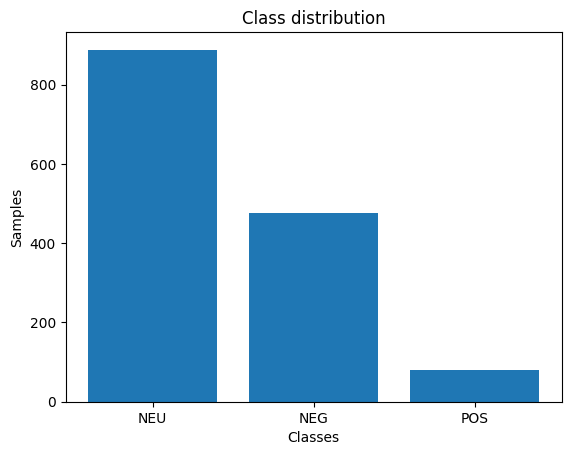

In [130]:
# Class distribution
labels_dist = train_df["label"].value_counts()

# Plot class distribution
plt.bar(labels_dist.index, labels_dist.values)
plt.title("Class distribution")
plt.xlabel("Classes")
plt.ylabel("Samples")
plt.show()

In [131]:
# Map labels to integers
label_map = {"NEG": 0, "NEU": 1, "POS": 2}
train_df["label"] = train_df["label"].map(label_map)

In [132]:
import re
import html

def clean_reddit_text(text):
    """
    Clean and normalize Reddit post text for sentiment analysis
    """
    if not isinstance(text, str):
        return ""
    
    # Unescape HTML entities
    text = html.unescape(text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove subreddit references and user mentions
    text = re.sub(r'/?[ru]/[A-Za-z0-9_-]+', '', text)
    
    # Remove markdown formatting
    text = re.sub(r'\*\*|\*|~~|__|_|\[|\]|\(|\)|>', '', text)
    
    # Handle [deleted] and [removed]
    text = re.sub(r'\[deleted\]|\[removed\]', '', text)
    
    # Remove edit notes
    text = re.sub(r'edit\s*:', '', text, flags=re.IGNORECASE)
    
    # Clean up whitespace and newlines
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [133]:
# Clean texts
train_df["text"] = train_df["text"].apply(clean_reddit_text)
# To lowercase
train_df["text"] = train_df["text"].str.lower()
print("Number of documents in train set after cleaning:", train_df.shape[0])
# Remove empty texts
train_df = train_df[train_df["text"].str.strip() != ""]
print("Number of documents in train set after removing empty texts:", train_df.shape[0])

Number of documents in train set after cleaning: 1443
Number of documents in train set after removing empty texts: 1443


In [134]:
train_df.head()

,id,country,keyword,text,label
0,A2442,Argentina,trans,me tiene los huevos al plato la gente que no q...,1
1,A0021,Argentina,gay,el che guevara era 100% antigay ¿cuál es tu fu...,1
2,A2678,Argentina,trans,no seas malo. es `trans` pero hay que dejarlo ...,0
3,A2016,Argentina,trans,imaginate defender a un tipo que golpea minas ...,1
4,A1844,Argentina,trans,"el no binario es difícil, no viví esa experien...",1


In [135]:
train_df.rename(columns={"text": "post content"}, inplace=True)
train_df.head()

,id,country,keyword,post content,label
0,A2442,Argentina,trans,me tiene los huevos al plato la gente que no q...,1
1,A0021,Argentina,gay,el che guevara era 100% antigay ¿cuál es tu fu...,1
2,A2678,Argentina,trans,no seas malo. es `trans` pero hay que dejarlo ...,0
3,A2016,Argentina,trans,imaginate defender a un tipo que golpea minas ...,1
4,A1844,Argentina,trans,"el no binario es difícil, no viví esa experien...",1


In [136]:
# Save cleaned data
train_df.to_csv(data_path + "dev_cleaned.csv", index=False)

In [86]:
from sklearn.model_selection import train_test_split

# Split data
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=RANDOM_SEED, stratify=train_df['label'])

print("Number of documents in train set:", train_df.shape[0])
print("Number of documents in validation set:", val_df.shape[0])

Number of documents in train set: 1010
Number of documents in validation set: 433


In [87]:
print("Class distribution in train set")
counts_train = train_df["label"].value_counts()
print(counts_train)
print("Class distribution in validation set")
counts_val = val_df["label"].value_counts()
print(counts_val)

LABELS = counts_train.index.to_list()
print("Labels:", LABELS)

Class distribution in train set
label
1    622
0    332
2     56
Name: count, dtype: int64
Class distribution in validation set
label
1    266
0    143
2     24
Name: count, dtype: int64
Labels: [1, 0, 2]


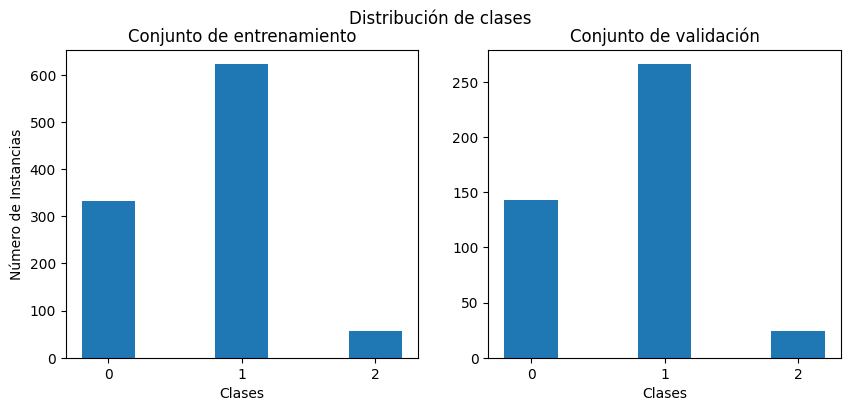

In [88]:
fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Distribución de clases')
ax_train.bar(LABELS, counts_train, width=0.4)
ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')
ax_train.set_xticks(LABELS)

ax_val.bar(LABELS, counts_val, width=0.4)
ax_val.set_title('Conjunto de validación')
ax_val.set_xlabel('Clases')
ax_val.set_xticks(LABELS)

plt.show()

In [89]:
length_train=train_df["text"].apply(lambda text: len(text.split()))
length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    1010.000000
mean       86.545545
std       139.492583
min         3.000000
25%        23.000000
50%        47.000000
75%       100.000000
90%       186.000000
95%       250.550000
99%       587.740000
max      2249.000000
Name: text, dtype: float64

In [90]:
length_val=val_df["text"].apply(lambda text: len(text.split()))
length_val.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count     433.000000
mean       92.281755
std       130.209283
min         4.000000
25%        25.000000
50%        53.000000
75%       108.000000
90%       207.400000
95%       311.400000
99%       578.760000
max      1737.000000
Name: text, dtype: float64

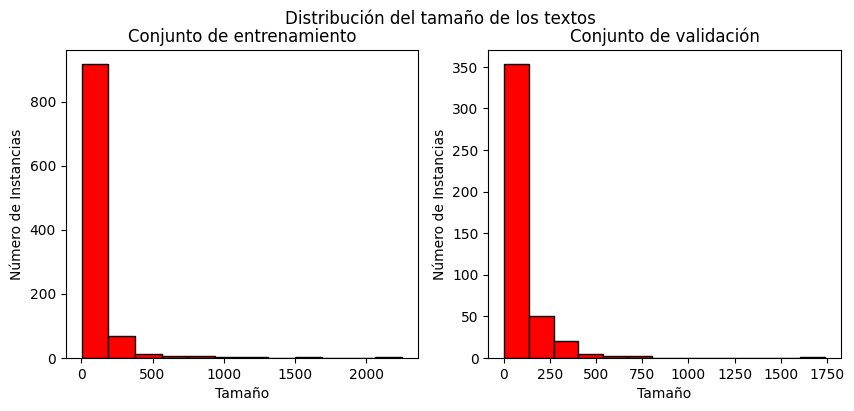

In [91]:
fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Distribución del tamaño de los textos')

ax_train.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(600/50))
ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Tamaño')
ax_train.set_ylabel('Número de Instancias')

ax_val.hist(length_val,  color = 'red', edgecolor = 'black',
         bins = int(200/15))
ax_val.set_title('Conjunto de validación')
ax_val.set_xlabel('Tamaño')
ax_val.set_ylabel('Número de Instancias')

plt.show()

In [92]:
# Save data
save = False

if save:
    train_df.to_csv(data_path + "train.csv", index=False)
    val_df.to_csv(data_path + "val.csv", index=False)
    print("Data saved")

Text(0, 0.5, 'Densidad')

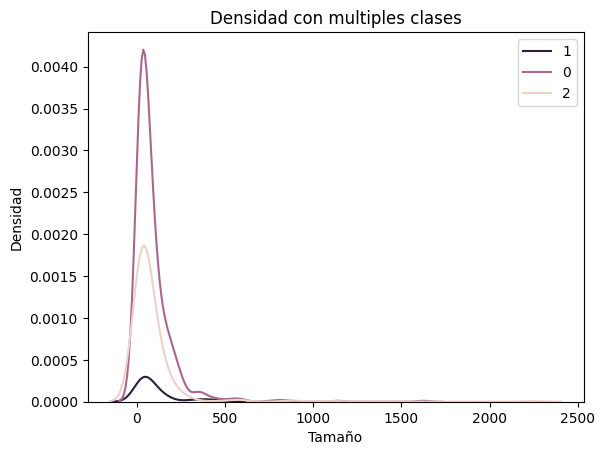

In [93]:
import seaborn as sns

train_df['Length'] = train_df['text'].apply(lambda text: len(text.split()))
sns.kdeplot(data=train_df, x='Length', hue='label')
plt.legend(LABELS)
plt.title('Densidad con multiples clases')
plt.xlabel('Tamaño')
plt.ylabel('Densidad')

In [94]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 
# Wordcloud with positive tweets
positive_tweets = df['tweet'][df["sentiment"] == 'Positive']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
 
# Wordcloud with negative tweets
negative_tweets = df['tweet'][df["sentiment"] == 'Negative']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


ModuleNotFoundError: No module named 'wordcloud'